In this notebook we explore Ridge Regression and what it might be good for

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
from __future__ import division
import seaborn as sns
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
sns.set(style='ticks', palette='Set2')
%matplotlib inline

Recall that the Ordinary Least Squares (OLS) regression solution for the linear model $y = X\beta + e$, is given by

$$
\arg\min_{\beta}: \,\, \|X \beta - y\|_2^2 = \arg\min_{\beta}{\rm SSE}(\beta)
$$

Regularization adds a penalty. Ridge regression adds a squared penalty which serves to regularize and shrink the coefficients:

$$
\arg\min_{\beta}{\rm SSE}(\beta) + \lambda \sum \beta_i^2 = \arg\min_{\beta}{\rm SSE}(\beta) + \lambda \|\beta\|_2^2
$$

# Some Examples

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


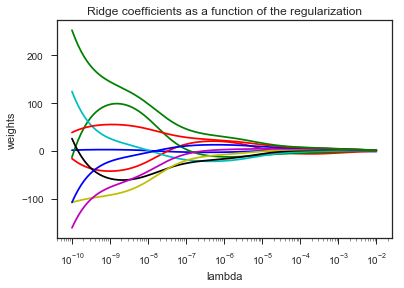

In [13]:
# A first (stylized) example of what Ridge Regression does

# We generate the data
# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10) + np.random.rand(10)/100


# then we plot the results
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
clf = linear_model.Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)

###############################################################################
# Display results

ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Another example: Correlated / Co-linear columns

In [266]:
# correlated columns
# Suppose p = 5, n = 500 -- a good ratio
p = 5; n = 500
X = np.random.randn(n,p)
c = np.dot(X[:,0:p-1],[2,3,-1,0.5]) + np.random.randn(1,n)/1000;
# c is a column that is approximately a linear combination of
# columns 1, 2, 3 and 4. We set the 5th column of X equal to c
X[:,p-1] = c
beta = np.array([1,1,1,1,0])
sigma = 0.3333
y = np.dot(X,beta) + sigma*np.random.randn(n)
# Now let's also generate a test data set
n1 = 500 # number of testing points
X_test = np.random.randn(n1,p)
c_test = np.dot(X_test[:,0:p-1],[2,3,0,0.5]) + np.random.randn(1,n1)/1000;
X_test[:,p-1] = c_test
y_test = np.dot(X_test,beta) + sigma*np.random.randn(n1)

In [268]:
# Note that the matrix Z = X'X has a very small eigenvalue.
Z = np.dot(X.T,X)
np.linalg.eig(Z)[0]

array([6.83853830e+03, 3.35532690e-05, 5.15404276e+02, 4.57012739e+02,
       4.84127416e+02])

In [269]:
# That means that its inverse has some very big eigenvalues.
# In fact, recall that the eigenvalues of the inverse matrix
# are always the inverse (one over) the eigenvalues of the original
# matrix.
np.linalg.eig(np.linalg.inv(Z))[0]

array([2.98033552e+04, 1.46230080e-04, 2.18812282e-03, 1.94022449e-03,
       2.06557193e-03])

In [270]:
# And remember that the formula for beta is
# beta_hat = (X'X)^-1 X'y
# and if we plug in: y = X beta* + Noise 
# (where beta* is the true solution), we get
# beta_hat = beta* + (X'X)^-1 X' Noise
#
# Multiplying the noise by (X'X)^-1 has the potential to blow up the noise
# and this is exactly what happens.

beta_hat = np.dot(np.dot(np.linalg.inv(Z),X.T),y.T)
print(beta_hat)

[-18.58779411 -28.42096221  10.79733255  -3.89422117   9.80389864]


To see that this is indeed "noise applification" go up a few cells and set sigma = 0 (it's set to 0.333 in the original version of this notebook). When you do that, you are setting the additive error in "y = X \beta + Noise" to zero. Hence there is no noise to amplify. Hence there are no problems with the huge eigenvalues of (X'X)^-1, and we still recover the correct answer. But even a little bit of error, and this goes out the window.

In [271]:
# Now let's compute the test error of OLS.
# You can see that it's not that good (it's big).
np.linalg.norm(np.dot(X_test,beta_hat) - y_test)

201.8171676096967

In [272]:
# For comparison, the true error for the optimal beta is:
np.linalg.norm(np.dot(X_test,beta) - y_test)

6.99761261441162

In [276]:
# Now we will add some regularization -- aka weight decay.
# Linear regression plus weight decay also has a closed form solution:
#
# beta_hat_R = (X'X + mu I)^-1 X'y -- compare to beta_hat = (X'X)^-1 X'y
# where I is the p by p identity matrix.
# 
# Adding a small multiple of the identity to X'X barely changes the large eigenvalues, 
# but it drastically changes the smallest eigenvalue -- it increases it to mu.
# Thus in the inverse, the largest eigenvalue will be at most 1/mu.
# Let's see this in action
#
mu = .15
print(np.linalg.eig(Z)[0])
print(np.linalg.eig(Z + mu*np.eye(p))[0])

[6.83853830e+03 3.35532690e-05 5.15404276e+02 4.57012739e+02
 4.84127416e+02]
[6.83868830e+03 1.50033553e-01 5.15554276e+02 4.57162739e+02
 4.84277416e+02]


In [277]:
# Now we can form the solution to the weight-decay problem, using
# the closed-form formula from above
beta_hat_R = np.dot(np.dot(np.linalg.inv(Z + mu*np.eye(p)),X.T),y.T)
print(beta_hat_R)

[0.42267094 0.09451293 1.29158149 0.85808426 0.29875498]


Note that in the above, the values are all much more controlled. There is no "error explosion" as in the OLS case. You may ask, however: why don't we recover the solution beta* = [1,1,1,1,0]? 

In fact, we cannot. Think about a case where two columns (say, columns 1 and 2) are identical. Then there's nothing the data can do to differentiate between putting weight on column 1 or column 2 or somehow splitting it between the two. {\em Any of these options produces exactly the same prediction function}. And note that since column 5 is twice the first plus 3 times the second minus the third plus 1/2 times the fourth, we have above precisely the right solution: 0.53794428 + 2 * 0.23421377 is approximately 1. 0.30061129 + 3 * 0.23421377 is approximately 1. 1.2239305 - 0.23421377 is approximately 1. And 0.87410259 + (1/2)*0.23421377 is approximately 1.

In [278]:
# Finally, let's compute the test error for the ridge regression solution.
np.linalg.norm(np.dot(X_test,beta_hat_R) - y_test)

9.109412861509012

In [280]:
# Let's again see the original solution, 
# the OLS solution (noise explosion), and the weight-decay version
# (aka ridge regression)
print(beta)
print(beta_hat)
print(beta_hat_R)

[1 1 1 1 0]
[-18.58779411 -28.42096221  10.79733255  -3.89422117   9.80389864]
[0.42267094 0.09451293 1.29158149 0.85808426 0.29875498]


In [90]:
# And let's again print the test error for the original solution,
# the OLS solution (and hence the impact of noise explosion)
# and then the weight-decay (ridge regression) version.
#
# As you can see, the Ridge-Regression solution has test error
# far far closer to the error of the true solution, than
# the OLS solution does.

print(np.linalg.norm(np.dot(X_test,beta) - y_test))
print(np.linalg.norm(np.dot(X_test,beta_hat) - y_test))
print(np.linalg.norm(np.dot(X_test,beta_hat_R) - y_test))

7.12112005415797
1619.4005683266043
38.620380394622615
